In [1]:
import pandas as pd
import numpy as np
from openeye import oechem, oedepict, oemolprop
import oenotebook as oenb
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Import output dataframe of XlogP_and_mw_filter.ipynb
df_mw= pd.read_csv("df_mw.csv")
df_mw.head()

,Unnamed: 0,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group
0,0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like
1,1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like
2,2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like
3,3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like
4,4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like


## 3. Filtering based on number of rotatable bonds

In [4]:
# Number of non-terminal rotatable bonds (excluding -OH)

df_mw["N_Rot"]=None

for i, row in enumerate(df_mw.iterrows()):
    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smiles)
    
    rotcounts = []
    nrots = oechem.OECount(mol, oechem.OEIsRotor())
    while nrots >= len(rotcounts):
        rotcounts.append(0)
    rotcounts[nrots] += 1
    
    del mol
    number_of_rotatable_bonds = len(rotcounts) - 1
    #print ("Max rotors:", number_of_rotatable_bonds)
    #print(df_mw.loc[i,"eMolecules ID"])
    
    df_mw.loc[i,"N_Rot"]= number_of_rotatable_bonds 

df_mw.head()

,Unnamed: 0,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot
0,0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1
1,1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3
2,2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2
3,3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2
4,4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like,5


In [5]:
# Number of rotatable bonds in fragment-like group shoud be <= 8
df_drug = df_mw.loc[df_mw["group"] == "drug-like"]
df_drug_nrot_interval = df_drug.loc[df_drug["N_Rot"] <= 8]

print("Number of compounds suitable for drug-like group: ", df_drug_nrot_interval.shape[0])

Number of compounds suitable for drug-like group:  45


## 4. Filtering based on possible UV-chromophores

In [6]:
# For UV-metric pKa measurement UV chromophores absorbing in 200-400 nm are necessary.
# I will use presence of C=C-C=C, C=C-C=O or C=C-C=N  substructures as an indictato of UV-chromophore
# 1.3-butadiene absorbs at 217 nm

df_mw["N_UV_chrom"]=None

UV_chromophore_SMARTS = "[n,o,c][c,n,o]cc"

for i, row in enumerate(df_mw.iterrows()):

    # Count number UV absorbing conjugated-pi systems using SMARTS matching

    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))

    #create a substructure search object
    queried_substructure = UV_chromophore_SMARTS
    ss = oechem.OESubSearch(queried_substructure)
    oechem.OEPrepareSearch(mol, ss)

    # loop over matches to count
    matched_ss_list=[]
    UV_chromophore_count = 0
    for index, match in enumerate(ss.Match(mol)):
        if ss.SingleMatch(mol) == True:
            matched_ss_list.append((index, match))
            UV_chromophore_count = len(matched_ss_list)
    
    df_mw.loc[i, "N_UV_chrom"] = UV_chromophore_count

df_mw.head()

,Unnamed: 0,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom
0,0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1,15
1,1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3,41
2,2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2,9
3,3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2,24
4,4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like,5,24


In [7]:
df_drug = df_mw.loc[df_mw["group"] == "drug-like"].reindex().reset_index(drop=True)
print("Number of compounds suitable for drug-like group: ", df_drug.shape[0])

# What is the minimum number of UV-chromophore matches in the drug-like and fragment-like group?
print("Minimum number of UV-chromophore units in drug-like group: ", min(df_drug["N_UV_chrom"]))

Number of compounds suitable for drug-like group:  47
Minimum number of UV-chromophore units in drug-like group:  12


## 5. Eliminate compounds with NaN price or availability

In [8]:
# Eliminate entries without price in drug-like ste
df_drug = df_drug[np.isfinite(df_drug["Price"])].reset_index(drop=True)

# Eliminate entries with availability less than 100 mg
df_drug = df_drug[df_drug["Availability (mg)"] >= 100.0].reset_index(drop=True)
print("Number of drug-like molecules with price and 100 mg availability:",df_drug.shape[0])

Number of drug-like molecules with price and 100 mg availability: 40


## 6. Sort molecules by their price

In [10]:
df_drug = df_drug.sort_values(by = "Price", ascending = True, inplace=False).reset_index(drop=True)

## 7. Eliminate compounds determined to have experimental logP reported

I run cycles of selecting 10 compounds for drug-like group and checking which ones have experimental logPs reported. eMolecules IDs of compounds with reported logPs were saved in a list, so that we can avoid them.

In [11]:
# TO DO

## 8. Include molecules with ring scaffolds of FDA approved PKIs
Murcko fragments of FDA approved Protein Kinase Inhibitors were created. I analyzed the frequency of appearance of ring fragments. The following rings were seen multiple times:
1. pyridine
2. piperazine
3. quinazoline
4. quinoline
5. pyrimidine
6. indazole
7. pyrazole
8. imidazole

I attempt to find drug-like molecules with the same scaffolds.

In [12]:
ring_smarts = {'pyridine':"c1cccc[nX2]1",
               'piperazine': "[NX3]1CC[NX3]CC1",
               'quinazoline': "c:1:c:2:c(:c:c:c:1):n:c:n:c:2",
               'quinoline': "c:1:c:2:c(:c:c:c:1):n:c:c:c:2",
               'pyrimidine': "c1[nX2]ccc[nX2]1",
               'indazole': "c1c2c(ccc1)nnc2",
               'pyrazole': "c1cnnc1",
               'imidazole': "c1nccn1"}

#How to record selected compounds
picked_ids=[]
df_drug["Selection"] = None
df_drug["Bin index"] = None
df_drug["Priority"] = None

# Find the cheapest compound that matches each ring 
for key, value in ring_smarts.items():
    queried_substructure = value
    
    # Iterate over compounds in the increasing price order
    for i, row in df_drug.iterrows():
        smiles = row["canonical isomeric SMILES"]
        
        # Substructure search
        mol = oechem.OEGraphMol()
        oechem.OESmilesToMol(mol, str(smiles))
        ss = oechem.OESubSearch(queried_substructure)
        oechem.OEPrepareSearch(mol, ss)

        # loop over matches to count
        matched_ss_list=[]
        count = 0
        for index, match in enumerate(ss.Match(mol)):
            if ss.SingleMatch(mol) == True:
                matched_ss_list.append((index, match))
                count = len(matched_ss_list)
        
        # If substructure matches and molecule already not selected
        if (count >= 1) and (df_drug.loc[i, "Selection"] != "picked"):
            df_drug.loc[i,"Selection"] = "picked"
            df_drug.loc[i,"Priority"] = 1
            print("Molecule that has {}: {}".format(key, smiles))
            break
 
    # If no match found
    if count == 0:
        print("Could not found a molecule that has {}!".format(key))

Could not found a molecule that has indazole!
Molecule that has pyridine: c1cc2c(cc(c(c2nc1)O)I)I
Molecule that has quinazoline: COc1cc2c(cc1OCCCN3CCOCC3)c(ncn2)Nc4ccc(c(c4)Cl)F
Could not found a molecule that has imidazole!
Molecule that has piperazine: CN1CCN(CC1)c2c(cccc2Cl)NC(=O)c3ccc(o3)Br
Molecule that has pyrimidine: CCOC(=O)c1ccc(cc1)Nc2cc(nc(n2)Nc3ccc(cc3)C(=O)OCC)C
Molecule that has pyrazole: CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl
Could not found a molecule that has quinoline!


## 9. Limit frequently appearing rings

### Limit multiple compounds with aminothiozole group
Aminothiozole group could be reactive and it is uncommon in medicinal screening libraries. Without this filter they showed up too frequenty in my fragment and drug sets. I will include only 1 molecule with 2-aminothiazole group.

### Limit the other frequent groups
1. thiophene
2. 5-methylenethiazolidine-2,4-dione
3. 1,3,4-thiadiazole

Without this filter they showed up too frequenty in my fragment and drug sets. 
I will select one compound from these groups and eliminate replicates.

In [13]:
ring_smarts_to_limit = {
               'aminothiazole': "[c,C]~1(~[nX2,NX2]~[c,C]~[c,C]~[s,S]~1)[NX3,nX3]",
               'thiophene': "c1cscc1",
               '5-methylenethiazolidine-2,4-dione': "[NX3,nX3]1[c,C]([s,S][c,C]([c,C]1=[O,o])=[C,c])=[O,o]",
               '1,3,4-thiadiazole': "n1:csc:n1"}

# Find the cheapest compound that matches each ring 
for key, value in ring_smarts_to_limit.items():
    queried_substructure = value
    
    # Iterate over compounds in the increasing price order
    for i, row in df_drug.iterrows():
        smiles = row["canonical isomeric SMILES"]
        
        # Substructure search
        mol = oechem.OEGraphMol()
        oechem.OESmilesToMol(mol, str(smiles))
        ss = oechem.OESubSearch(queried_substructure)
        oechem.OEPrepareSearch(mol, ss)

        # loop over matches to count
        matched_ss_list=[]
        count = 0
        for index, match in enumerate(ss.Match(mol)):
            if ss.SingleMatch(mol) == True:
                matched_ss_list.append((index, match))
                count = len(matched_ss_list)
        
        # If substructure matches and molecule already not selected
        if (count >= 1) and (df_drug.loc[i, "Selection"] != "picked"):
            df_drug.loc[i,"Selection"] = "picked"
            df_drug.loc[i,"Priority"] = 1
            print("Molecule that has {}: {}".format(key, smiles))
            break
 
    # If no match found
    if count == 0:
        print("Could not found a molecule that has {}!".format(key))
 

Molecule that has 5-methylenethiazolidine-2,4-dione: c1cc(cc(c1)OCc2ccc(cc2Cl)Cl)/C=C/3\C(=O)NC(=O)S3
Molecule that has thiophene: Cc1ccc(cc1C)c2csc(c2C(=O)N)NC(=O)CCCC(=O)O
Molecule that has 1,3,4-thiadiazole: c1ccc(c(c1)C(=O)Nc2nnc(s2)SCc3ccc(cc3)F)Cl
Molecule that has aminothiazole: CCOc1ccc2c(c1)sc(n2)NC(=O)Cc3ccc(c(c3)Cl)Cl


In [14]:
df_drug_picked = df_drug[df_drug["Selection"]=="picked"]
df_drug_picked

,Unnamed: 0,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom,Selection,Bin index,Priority
1,89,10794751,CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl,O=C(Nc1cccc(c1Cl)Cl)Nc1cc(nn1c1ccccc1)C(C)(C)C,[4.113],5.784,403.305,324.5,148.0,drug-like,6,35,picked,None,1
2,20,3044617,c1ccc(c(c1)C(=O)Nc2nnc(s2)SCc3ccc(cc3)F)Cl,Fc1ccc(cc1)CSc1nnc(s1)NC(=O)c1ccccc1Cl,[6.525],5.237,379.859,121.5,148.0,drug-like,6,24,picked,None,1
3,29,3365457,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc3ccc(c(c3)Cl)Cl,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc1ccc(c(c1)Cl)Cl,[9.167],5.171,381.276,489.9,148.0,drug-like,6,28,picked,None,1
7,5,4038159,Cc1ccc(cc1C)c2csc(c2C(=O)N)NC(=O)CCCC(=O)O,OC(=O)CCCC(=O)Nc1scc(c1C(=O)N)c1ccc(c(c1)C)C,[4.663],2.314,360.427,100.0,168.0,drug-like,8,28,picked,None,1
8,96,536848,c1cc2c(cc(c(c2nc1)O)I)I,Ic1cc(I)c2c(c1O)nccc2,"[3.511, 6.794]",3.371,396.951,239.0,168.0,drug-like,0,29,picked,None,1
9,76,4375254,CCOC(=O)c1ccc(cc1)Nc2cc(nc(n2)Nc3ccc(cc3)C(=O)...,CCOC(=O)c1ccc(cc1)Nc1cc(C)nc(n1)Nc1ccc(cc1)C(=...,[6.336],2.937,420.461,319.0,168.0,drug-like,10,28,picked,None,1
11,141,876432,COc1cc2c(cc1OCCCN3CCOCC3)c(ncn2)Nc4ccc(c(c4)Cl)F,COc1cc2ncnc(c2cc1OCCCN1CCOCC1)Nc1ccc(c(c1)Cl)F,"[4.155, 6.994]",2.718,446.902,143.0,168.0,drug-like,8,36,picked,None,1
12,50,17664146,CN1CCN(CC1)c2c(cccc2Cl)NC(=O)c3ccc(o3)Br,CN1CCN(CC1)c1c(cccc1Cl)NC(=O)c1ccc(o1)Br,[7.773],3.109,398.682,379.0,168.0,drug-like,4,18,picked,None,1
22,61,46568819,c1cc(cc(c1)OCc2ccc(cc2Cl)Cl)/C=C/3\C(=O)NC(=O)S3,O=C1NC(=O)/C(=C\c2cccc(c2)OCc2ccc(cc2Cl)Cl)/S1,[8.05],5.238,380.245,154.0,219.0,drug-like,4,24,picked,None,1


Replace unwanted compounds:
- compound with iodines (eMolecules ID : 536848, SMILES="c1cc2c(cc(c(c2nc1)O)I)I") with another quinoline
- compound with bromine (eMolecules ID: 17664146, SMILES = "CN1CCN(CC1)c2c(cccc2Cl)NC(=O)c3ccc(o3)Br" with another piperazine)
- compound with titratable group too far from chromophore (eMolecules ID = 4038159, SMILES = "Cc1ccc(cc1C)c2csc(c2C(=O)N)NC(=O)CCCC(=O)O)") with another quanizoline

In [15]:
# Drop unwanted compounds
unwanted_eMol_IDs = [536848, 17664146, 4038159]
for eMol_ID in unwanted_eMol_IDs:
    df_drug_picked.loc[df_drug_picked["eMolecules ID"] == eMol_ID, "Selection"] = None
    df_drug.loc[df_drug["eMolecules ID"] == eMol_ID, "Selection"] == None

df_drug_picked = df_drug_picked.loc[df_drug_picked["Selection"] == "picked"].reset_index(drop=True)
print("Number of selected fragment-like molecules after removing unwanted molecules:",df_drug_picked.shape[0])

# Pick replacement compounds with quinoline and piperazine?

Number of selected fragment-like molecules after removing unwanted molecules: 6


/Users/isikm/opt/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(0, 10)

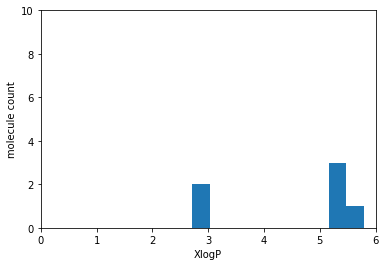

In [16]:
# Let's check the logP distribution of drug-like group
XlogP_values = df_drug_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [17]:
XlogP_values

0    5.784
1    5.237
2    5.171
3    2.937
4    2.718
5    5.238
Name: XlogP, dtype: float64

## 10. Select molecules for even coverage of logP dynamic range

While selecting from each logP bin, first compounds selected for their ring substructres will be assigned to each bin. Then for selecting more compounds I will prioritize cheaper compounds, based on the price sorted dataframes.

10 drug-like molecules will be selected.